<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Examples.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# Examples: Principal component analysis
 
© ExploreAI Academy

In this train, we learn about dimensionality reduction and choosing principal components to explain the highest variance in our data.

## Learning objectives

By the end of this train, you should be able to:

* Understand dimensionality reduction.
* Understand principal component analysis (PCA) as a method for dimensionality reduction. 
* Implement PCA in Python.

## Dimensionality reduction

A widely encountered problem in machine learning is that of dimensionality. We typically refer to the size or shape of a dataset as an $n$ x $p$ matrix, where each row from 1 to $n$ represents an observation or data point, and each column from 1 to $p$ represents a variable or feature. With each additional feature, the dimensionality of a dataset increases by 1.

The problems with increasing or high levels of dimensionality are as follows:

- More storage space required for the data;
- More computation time required to work with the data; and
- More features mean more chance of feature correlation, and hence feature redundancy.

The latter point is the basis on which **principal component analysis** is carried out. A feature that is highly correlated with another increases when the other increases (positive correlation) or decreases when the other increases (negative correlation). This is helpful because if multiple features tend to behave in a corresponding manner in the dataset, they can often be replaced by some smaller number of representative feature(s). This helps to lower the feature space within which the data reside, reducing computation time as well as storage capacity requirements.

The goal of dimensionality reduction is to **reduce the number of features in a dataset while minimising the amount of data loss**. There are three primary methods by which this can be done:

- Principal Component Analysis (PCA)
- Linear Discriminant Analysis (LDA)
- Generalised Discriminant Analysis (GDA)

In this notebook, we will focus on **PCA**.

## Principal component analysis

The premise of PCA is that data in some higher number of dimensions can be mapped to some lower number of dimensions whilst retaining the maximum amount of variance in the lower dimension. Broadly speaking, the following steps are involved in a PCA:

1. Perform feature scaling on data; 
2. Construct the covariance matrix of the data;
3. Compute the eigenvectors of this matrix. The eigenvectors corresponding to the largest eigenvalues are used to reconstruct a maximal fraction of variance of the original data.

These are unfamiliar terms, which we encourage you to investigate on your own. The general idea is that we are able to compute a vector within the feature space of the dataset, which points in the direction of the maximum variance found in the data. This vector is known as the principal component, and we say that it _explains_ the most variance.

The second principal component is that vector which is orthogonal (mutually perpendicular) to the first principal component, and which again explains the maximum variance in this orthogonal direction. The third principal component is orthogonal to both of the first two and explains the maximum variance in that direction.

This continues for each additional principal component until the maximum number of `p` principal components (there cannot be more principal components than there are features). 100% of the variance can only be explained by all `p` of the features, so we expect to lose some data while reducing the number of dimensions. However, because the principal components are orthogonal and ranked in decreasing order of variance explained, we do normally expect that some subset of all the features will explain a significant proportion of the data.

Below is an image which summarises the steps involved in PCA:

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://github.com/Explore-AI/Pictures/blob/master/sketch-pca-diagram.png?raw=true")

### Applying PCA to real data

The dataset we will use is from the US census of 2015. It contains demographic information such as population, proportion of race, gender, income, child poverty, etc, for each county in the US. A county is a geographic area which is larger than a city but smaller than a state. There are over 3000 counties in the dataset, which should provide sufficient information to perform PCA with.

Let's start this example by importing all the packages we'll need, then bring in the data and see what it looks like. 

> Note: You will need to install the `cufflinks` and `plotly` libraries to generate the plots in this section. Check out [this guide](https://github.com/plotly/plotly.py#jupyterlab-support-python-35) for more help.

> Also ensure that you are using a `numpy` version < 2, otherwise you might encounter this error: `ValueError: numpy.dtype size changed, may indicate binary incompatibility`

In [2]:
import numpy as np
import pandas as pd
import cufflinks as cf
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
us_df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/unsupervised_sprint/acs2015_county_data.csv', encoding="UTF-8").dropna()
us_df.head(5)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [ ]:
us_df.shape

Observing the first few rows of the data and then seeing the shape above, we note that there are 37 columns. Not all of these columns are numeric and some of them, like `ID`, `State` and `County`, could be considered labels. Labels are not used in an unsupervised learning environment - but perhaps they will be of use to us later in validating the clusters in the next train. For now, let's remove those columns.

In [4]:
# create short list of unwanted columns
labels = ['CensusId', 'State', 'County']

# declare the features to be all columns, less the unwanted ones from above
features = [col for col in us_df.columns if col not in labels]

### Scales of measurement

The most important preprocessing step for our data before any dimensionality reduction may take place is **scaling**.

Scaling data is vitally important because not all variables are measured on the same scales and/or using the same units. For instance, the age variable will have a range of 0 to approximately 95, with a mean somewhere around 40. Income, however, will be measured over a much larger numeric range, well into the thousands or millions, with a very different mean. Let's take a look at box plots of the first few variables to better understand this measurement discrepancy.   

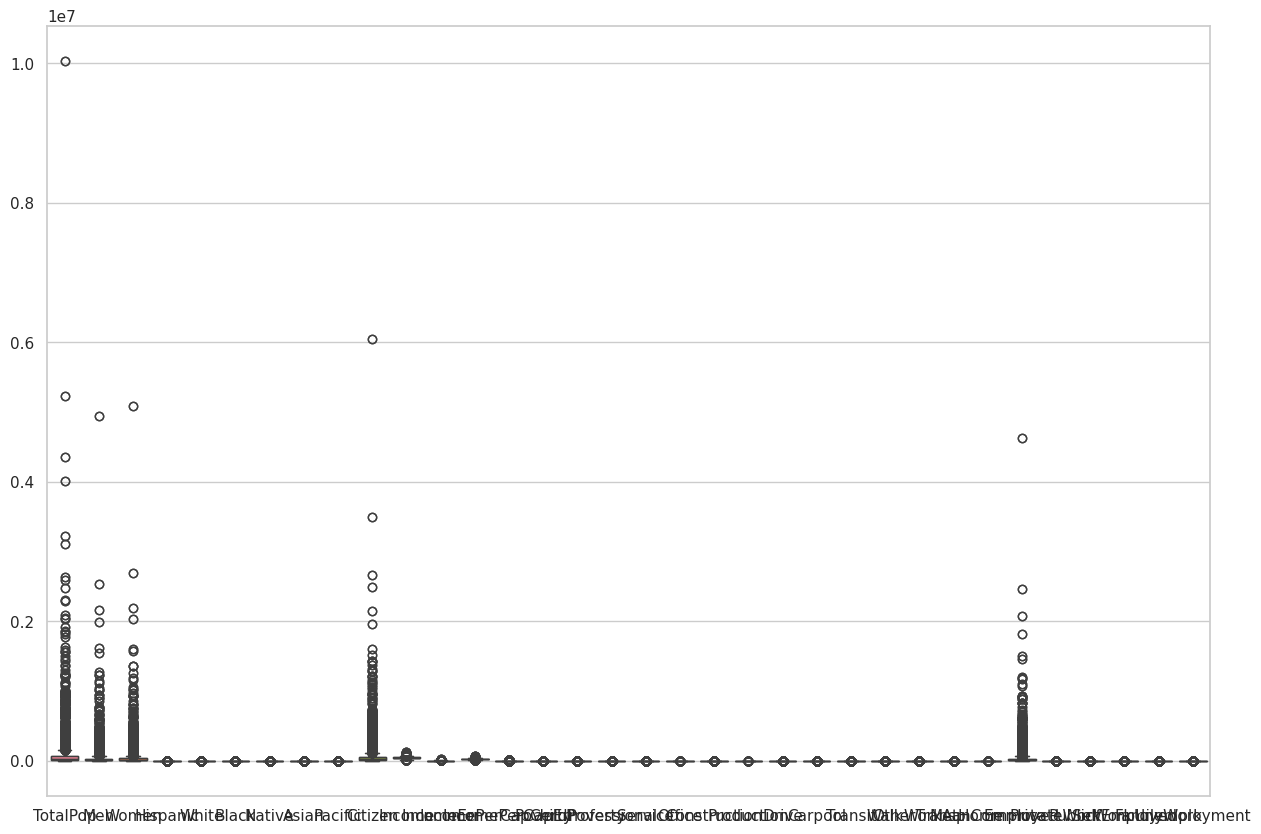

In [6]:
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')

# # using plotly to plot the boxplot
# us_df[features].iplot(kind='box', title="Boxplots of Features (Unscaled)")

sns.boxplot(us_df[features])
plt.show()

Clearly, the scales used for percentage-based variables are very different from population-based ones. Let's scale the columns, and plot the boxplots again for the same variables.

> Note: If the following cell times out with a warning, check out [this stackoverflow](https://stackoverflow.com/questions/43288550/iopub-data-rate-exceeded-in-jupyter-notebook-when-viewing-image) for more help.

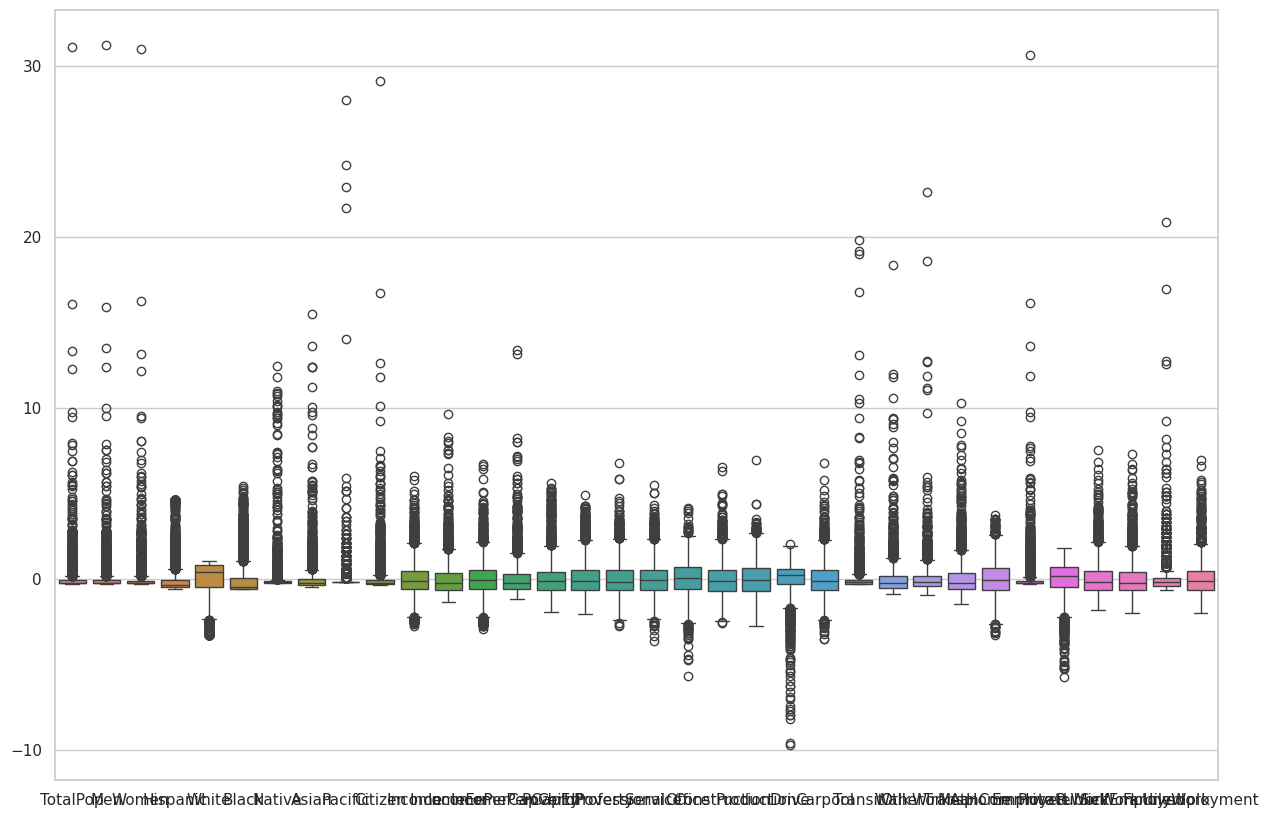

In [8]:
# define scaled data frame variable
us_df_scaled = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/unsupervised_sprint/acs2015_county_data.csv', encoding="UTF-8").dropna()
us_df_scaled[features] = preprocessing.scale(us_df_scaled[features])

# # plot boxplots using scaled data
# us_df_scaled[features].iplot(kind='box', title="Boxplots of Features (Scaled)")

sns.boxplot(us_df_scaled[features])
plt.show()

All the features now have a mean of zero and a variance of one, but their boxplots remain the same shape.

Let's use what we have learned thus far to interpret an important graph. We'll generate a PCA object and fit the features in the scaled data frame to it. We'll then plot a line graph showing the cumulative variance explained versus the increasing number of components. Remember, the only way to retain 100% of the variance is to retain 100% of the components.

Conducting PCA using `sklearn` is simple and can be done with just a few lines of code. We first define a PCA object, then fit it to our data and apply the dimensionality reduction. If this was a supervised learning setting and we had a test set, we could simply apply the dimensionality reduction to it using `pca.transform(X_test)`.

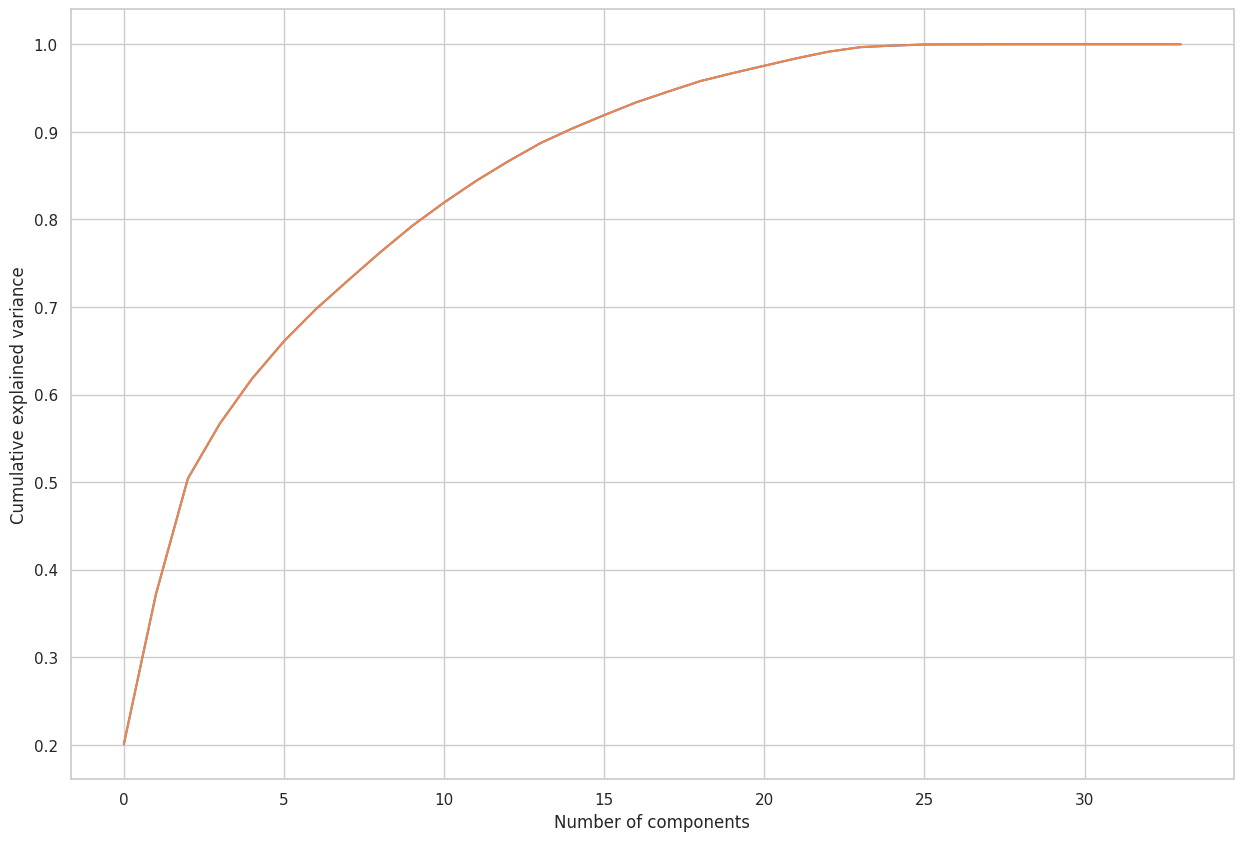

In [10]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(us_df_scaled[features])

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)

pca_df["state"] = us_df["State"]

# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

As this is a lesson in dimensionality reduction, we'll need to make a compromise: trading variance retained for components kept. Let's set an arbitrary threshold for the desired variance retained of 85% - that is, we want to determine how many principal components will be required to explain 85% of the variance in our dataset. Looking at the graph, it appears roughly 12 components will explain 85% of the data. That is a significant reduction - from 34 features down to 12. Interestingly, it appears that close to 100% of the variance is explained by the first 23 components, itself a significant reduction.

Let's check what the actual number of components would be for 85% variance retention.

In [11]:
pca_85 = PCA(.85)
pca_85.fit_transform(us_df_scaled[features])
print(round(pca_85.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_85.n_components_,
      "components.")

86.6 % of variance explained by 13 components.


Indeed, visualising 13 components is not much easier for a human than 34, but the reduction will certainly lower computation time when working with this dataset. Let's take a look at the variance explained by the first few components.

In [16]:
pca.explained_variance_ratio_[:3]

array([0.20059818, 0.17109461, 0.13235941])

In this instance, the first component explains 20%, with the 2nd following closely behind at 17% and the 3rd at 13%. Together, the first three components explain 50% of the data, which is quite a significant achievement considering it is less than a tenth of the total number of original components.

Let's plot the first two components on a 2D scatter plot.

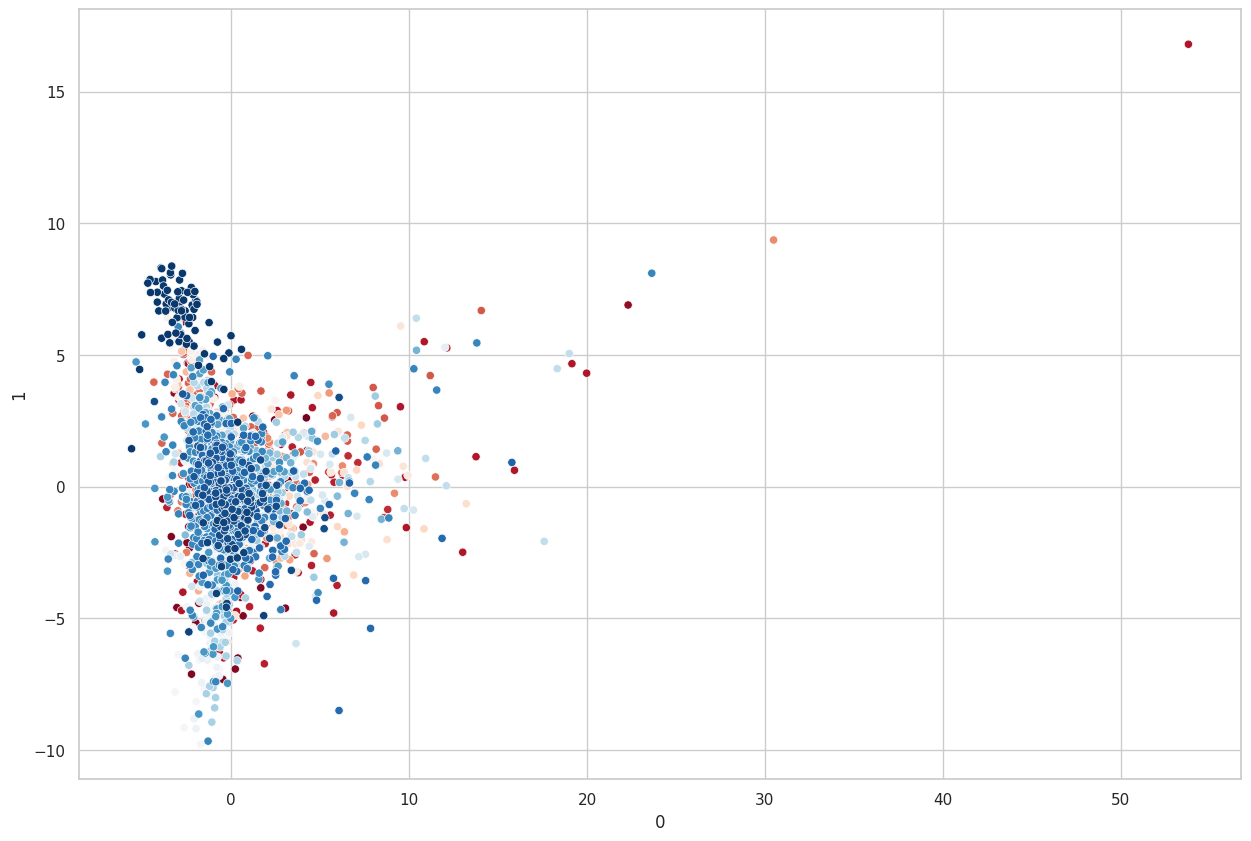

In [17]:
ax = sns.scatterplot(x=pca_df[0], y=pca_df[1],
                     hue="state",
                     palette='RdBu',
                     data=pca_df,
                     legend=False)
plt.show()

### Putting our dimensionality reduction to use

We have seen that just 13 components of an original 34 can be used to explain 86.6% of the variance in our dataset. Let us now utilise our reduced dataset, consisting of just 13 components, by using it to build a predictive regressor model.

We will use the feature named `IncomePerCap` as the response variable (the one that we will try to predict). This feature was used in our initial PCA, so we will have to make some changes to the dataset to ensure it is not included this time.

PCA requires features to be scaled, as we mentioned above. But we don't need to scale the response variable which we will use for prediction, as it is not used in PCA. This is good, because leaving the response as it is means any predicted values and associated errors are easier to interpret. 

In [18]:
# exclude non-features from data
reg_data = us_df_scaled[features]

# set aside response variable (Unscaled!)
reg_response = us_df["IncomePerCap"]

# drop response variable
reg_data = reg_data.drop(['IncomePerCap'], axis=1)

Now, let's split the dataset up into train and test using an arbitrary ratio of 80/20 (train/test, respectively).

In [19]:
X_train, X_test, y_train, y_test = train_test_split(reg_data, reg_response, test_size=0.2)

Next, we apply PCA to the training set with the number of components set to 13.

In [20]:
# create PCA object with n_components set to 13
pca_reg = PCA(n_components=13)

# fit the PCA model to our data and apply the dimensionality reduction 
X_train = pca_reg.fit_transform(X_train)

# confirm the number of components
pca_reg.n_components_

13

In [21]:
pca_reg.explained_variance_ratio_.sum()

np.float64(0.87091530740774)

We have now reduced our dataset of 33 features into just 13 components. Let's continue by applying the same reduction transformation to the test set.

In [22]:
X_test = pca_reg.transform(X_test)

We'll make use of a random forest regression model to do our predictions.

In [23]:
# instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, n_jobs=-1, random_state = 101)

# train the model on training data
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",1000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

Now we'll use the trained model to make predictions from the test set.

In [24]:
# use the forest's predict method on the test data
predictions = rf.predict(X_test)

# calculate the absolute errors
errors_reg = abs(predictions - y_test)

# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_reg), 2))

Mean Absolute Error: 1751.79


This model is able to predict `IncomePerCap` values with a mean absolute error of around $1700. Is that good? Well, let's take a look at the median income.

In [25]:
reg_response.agg("median")

np.float64(23457.5)

In [26]:
print("Predicts IncomePerCap to within", round((round(np.mean(errors_reg), 2)/reg_response.agg("median"))*100, 1), "% of its value.")

Predicts IncomePerCap to within 7.5 % of its value.


The median income value is $23,457, which means our model is able to predict to within ~7% of the actual value on average.

We have managed to make predictions using our reduced dataset, but we have no benchmark metric with which to compare our results. We'll need to train a similar model using our original dataset and check its prediction accuracy.

In [27]:
# create features and response data from full dataset
features = us_df_scaled[features].drop(['IncomePerCap'], axis=1)
response = us_df['IncomePerCap']

# split original data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(features, response, test_size=0.2)

# instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, n_jobs=-1, random_state = 101)

# train the model on training data
rf.fit(X_train_orig, y_train_orig)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",1000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

In [28]:
# use the forest's predict method on the test data
predictions = rf.predict(X_test_orig)

# calculate the absolute errors
errors = abs(predictions - y_test_orig)

# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1431.84


In [29]:
print("Predicts IncomePerCap to within", round((round(np.mean(errors), 2)/reg_response.agg("median"))*100, 1), "% of its value.")

Predicts IncomePerCap to within 6.1 % of its value.


Using the entire dataset, in other words, all 33 features, we are only able to predict `IncomePerCap` to within 6% of its actual value, on average!

Thus, it seems using dimensionality reduction here was effective - we reduced the number of features from 33 to 13, and the error in prediction only worsened by 1% (from 6% to 7%). You can imagine that this would be very useful with an extremely large dataset.

### Advantages and disadvantages of PCA 

**Advantages**:
- Effective at finding optimal representation of a dataset with fewer dimensions
- Effective at decreasing redundancy and filtering noise  
- Visualisation of datasets with high-dimensionality
- Improves performance of algorithm 

**Disadvantages**:
- May result in some loss of information
- Variables may become less interpretable after being transformed


## Conclusion

You have now learnt what dimensionality reduction means and why one would use it. You have seen how using PCA can be effective in reducing the dimensions and thus the computational complexity when performing regression. Purpose to experiment with the above example to gain a further understanding of PCA and its uses.

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>